# **UPLOAD cleaned_transcripts.csv first before running all cells! **

# Importing Necessary Modules 

In [ ]:
import pandas as pd
import numpy as np

#word stemming
import nltk
nltk.download('punkt')
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

#data processing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential 
from keras.layers import Dense, Embedding, Flatten 
from keras.datasets import imdb 
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import clone
import random
from sklearn.utils import shuffle



#Visualization 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#Under and Oversampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

#Evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score


#models
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [ ]:
filepath = "/content/clean_compiled_transcripts.csv"
df_transcript = pd.read_csv(filepath)

column_list = df_transcript.columns.tolist()
print(column_list)

df_transcript.head(10)

# Procesing Data 

In [ ]:
def stem_text(text):
    ps = PorterStemmer()
    text = text.split()
    stemmed_text = []
    for w in text: 
        stemmed = ps.stem(w)
        stemmed_text.append(stemmed)
    return stemmed_text

stem_text("i my you me they we she he myself her shes")

In [ ]:
original_text = df_transcript.Transcript[0]
# df_transcript.Transcript = df_transcript.Transcript.apply(stem_text)
# filtered_text = df_transcript.Transcript[300]

print(f"The original text is:\n{original_text}")
# print("-------------------------------------------")
# print(f"The filtered text is:\n{filtered_text}")

# Creating Training and Test Data 

In [ ]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
corpus = df_transcript["Transcript"]
x = vectorizer.fit(corpus)
x = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_
phq_Score = df_transcript["PHQ_Score"]
phq_Binary = df_transcript.PHQ_Binary.to_numpy()
print(x.shape)
# print(x)

x_dense = x.todense()
print(x_dense.shape)

# print(x_dense)

# wtf = np.asarray(x)
# # print(x.shape)
# print(wtf[0])

# x.shape
# np.save("x_tfidf", x)
# np.save("y_tfidf", phq_Binary)

# x_train, x_test, y_train, y_test = train_test_split(x, phq_Binary, test_size=0.2) 
# x_train.shape

# x_train_dense = x_train.todense()
# x_test_dense = x_test.todense()

# x.toarray()
# print(x.shape)
# print(x.shape[0])


# print(x_train.shape[0])
# print(y_train[1])

In [ ]:
def train_test(X, y, testfile):
    test_participants = pd.read_csv(testfile)['participant_ID'].values
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    
    for i in range(y.shape[0]):
        participant_no = y.index[i]
        # print(X[i])
        
        if participant_no in test_participants:
            X_test.append(X[i])
            y_test.append(y[participant_no])
        
        else:
            X_train.append(X[i])
            y_train.append(y[participant_no])
            
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [ ]:
testfile = './test_split_Depression_AVEC2017 (3).csv'
y =  pd.read_csv("./clean_compiled_transcripts.csv", index_col = "Participant_ID")['PHQ_Binary']

# x = np.array(x)
# x.shape
# print(x_dense.shape)
# print(X_train)

X_train, X_test, y_train, y_test = train_test(x_dense, y, testfile)

print(x_dense.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

X_train = X_train.reshape((136,10000))
X_test = X_test.reshape((45,10000))

y_train = y_train.reshape((136)) 
y_test = y_test.reshape((45))

print(x_dense.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

## Undersampling

In [ ]:
RANDOM_STATE = 42

# because the RandomUnderSampler does not work here
def undersampling(X_train, y_train):
    random.seed(RANDOM_STATE)
    
    neg_list = [i for i in range(len(y_train)) if y_train[i] == 0]
    pos_list = [i for i in range(len(y_train)) if y_train[i] == 1]
    
    if len(neg_list) < len(pos_list):
        minority_list = neg_list
        majority_list = pos_list
    else:
        minority_list = pos_list
        majority_list = neg_list
        
    sampled_list = random.sample(majority_list, len(minority_list))
    
    final_list = sampled_list + minority_list
    
    X_train_us = []
    y_train_us = []
    
    for i in final_list:
        X_train_us.append(X_train[i])
        y_train_us.append(y_train[i])
                                 
    return np.array(X_train_us), np.array(y_train_us)

xu_train, yu_train = undersampling(X_train, y_train)

In [ ]:
# shuffle the train data in unison because data is in order
# reduces poor performance during k-cross validation when sampling data

xu_train, yu_train = shuffle(xu_train, yu_train, random_state=RANDOM_STATE)

xu_train.shape, X_test.shape, yu_train.shape, y_test.shape

# Visualizaiton of TFIDF 
Conclusion: There are no obvious clusters from the visualizations of these vectors 

## Overall Dataset

In [ ]:
num_clusters = 2
num_seeds = 10
max_iterations = 300

labels_color_map = {
    0: '#20b2aa', 1: '#ff7373'
}

pca_num_components = 2
tsne_num_components = 2

labels = phq_Binary
# print labels

# ----------------------------------------------------------------------------------------------------------------------

reduced_data = PCA(n_components=pca_num_components).fit_transform(x_dense)
# print reduced_data

fig, ax = plt.subplots()

A = 0 #counter for green and y = 0 
B = 0 #counter for red and y = 0
C = 0 #counter for green and y = 1
D = 0 #counter for red & y = 1
    
for index, instance in enumerate(reduced_data):

    pca_comp_1, pca_comp_2 = reduced_data[index]
    color = labels_color_map[phq_Binary[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)

    y = phq_Binary[index]
    
    if y == 0 and color == '#20b2aa':
        A += 1
    elif (y == 0 and color == '#ff7373'):
        B += 1
    elif (y == 1 and color == '#20b2aa'): 
        C += 1
    elif (y == 1 and color == '#ff7373'):
        D += 1
        

print("Green: Not depressed")
print("Red: Depressed")
print(A,B,C,D)
    
plt.show()

# # t-SNE plot
# embeddings = TSNE(n_components=tsne_num_components)
# Y = embeddings.fit_transform(x_dense)
# plt.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)
# plt.show()

## Visualization of Training Data

### Normal Sample Set

Green: Not depressed (n =  95 )
Red: Depressed (n =  41 )
95 0 0 41


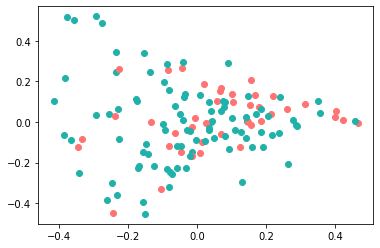

In [69]:
num_clusters = 2
num_seeds = 10
max_iterations = 300

labels_color_map = {
    0: '#20b2aa', 1: '#ff7373'
}

pca_num_components = 2
tsne_num_components = 2

labels  = y_train
# ----------------------------------------------------------------------------------------------------------------------

reduced_data = PCA(n_components=pca_num_components).fit_transform(X_train)
# print reduced_data

fig, ax = plt.subplots()

A = 0 #counter for green and y = 0 
B = 0 #counter for red and y = 0
C = 0 #counter for green and y = 1
D = 0 #counter for red & y = 1
    
for index, instance in enumerate(reduced_data):

    pca_comp_1, pca_comp_2 = reduced_data[index]
    y = y_train[index]
    color = labels_color_map[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
    
    if y == 0 and color == '#20b2aa':
        A += 1
    elif (y == 0 and color == '#ff7373'):
        B += 1
    elif (y == 1 and color == '#20b2aa'): 
        C += 1
    elif (y == 1 and color == '#ff7373'):
        D += 1
        

print("Green: Not depressed (n = ", A+B, ")")
print("Red: Depressed (n = ", C+D, ")")
print(A,B,C,D)
    
plt.show()


### Undersampling

Green: Not depressed (n =  41 )
Red: Depressed (n =  41 )
41 0 0 41


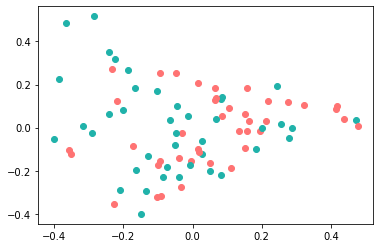

In [70]:
num_clusters = 2
num_seeds = 10
max_iterations = 300

labels_color_map = {
    0: '#20b2aa', 1: '#ff7373'
}

pca_num_components = 2
tsne_num_components = 2

labels = phq_Binary
# print labels

# ----------------------------------------------------------------------------------------------------------------------

reduced_data = PCA(n_components=pca_num_components).fit_transform(xu_train)
# print reduced_data

fig, ax = plt.subplots()

A = 0 #counter for green and y = 0 
B = 0 #counter for red and y = 0
C = 0 #counter for green and y = 1
D = 0 #counter for red & y = 1
    
for index, instance in enumerate(reduced_data):

    pca_comp_1, pca_comp_2 = reduced_data[index]
    color = labels_color_map[yu_train[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
    
    y = yu_train[index]
        
    if y == 0 and color == '#20b2aa':
        A += 1
    elif (y == 0 and color == '#ff7373'):
        B += 1
    elif (y == 1 and color == '#20b2aa'): 
        C += 1
    elif (y == 1 and color == '#ff7373'):
        D += 1
        

print("Green: Not depressed (n = ", A+B, ")")
print("Red: Depressed (n = ", C+D, ")")
print(A,B,C,D)
    
plt.show()

# Evaluation Metrics 

For depression, anything that doesn't account for false negatives could be harmful. Therefore, we take recall as a better measure than precision.

In [ ]:
def evaluate_on_training_set(y_test, y_pred):
  # Calculate AUC
  print("AUC is: ", roc_auc_score(y_test, y_pred))
  
  # print out recall and precision
  print(classification_report(y_test, y_pred, labels=np.unique(y_pred)))
  
  # print out confusion matrix
  print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

  # # calculate points for ROC curve
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  
  # Plot ROC curve
  plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')

In [ ]:
def k_cross(input_model, X, y, k=4, n=3, random_state=42):
    f1_scores = []
    recall_scores = []
    rkf = RepeatedKFold(n_splits=k, n_repeats=n, random_state=random_state)
    for train_index, val_index in rkf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model = clone(input_model)
        model.fit(X_train, y_train) 
        
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred)
        f1_scores.append(f1)
        recall = recall_score(y_val, y_pred)
        recall_scores.append(recall)
        
    return f1_scores, recall_scores, model

# Run Model 

In [ ]:
def run_model(input_model, X_train, X_test, y_train, y_test):
    model = input_model
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    evaluate_on_training_set(y_test, y_pred)
    
    return model

In [ ]:
# For k-cross

def run_kcross_model(input_model, X_test, y_test):
    y_pred = input_model.predict(X_test)
    evaluate_on_training_set(y_test, y_pred)
    return input_model

# Training Models

For each method, the normal, undersampling and oversampling methods were used. 

## Decision Tree Model

In [ ]:
def find_best_tree_model(upper_depth, upper_leaf, X_train, y_train):
    best_f1_model = None
    best_f1 = -1
    best_recall = -1
    
    for depth in range(1, upper_depth + 1):
        for leaf in range(1, upper_leaf + 1):
            model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth, min_samples_leaf=leaf) 
            
            f1_scores, recall_scores, model = k_cross(model, X_train, y_train)
            f1 = np.mean(f1_scores)
            recall = np.mean(recall_scores)
            
            if f1 > best_f1:
                best_f1 = f1
                best_recall = recall
                best_f1_model = model
    
    print(f"best scores: f1 = {best_f1}, recall = {best_recall}")
    
    return best_f1_model

In [56]:
best_tree_f1_model = find_best_tree_model(20, 30, X_train, y_train)

best scores: f1 = 0.48364911256215604, recall = 0.5783799533799534


In [58]:
best_tree_f1_model = find_best_tree_model(20, 30, xu_train, yu_train)

best scores: f1 = 0.6121386717782599, recall = 0.642296361046361


## Random Forest Model 

In [59]:
def find_best_forest_model(n_estimators, X_train, y_train):
    best_f1_model = None
    best_f1 = -1
    best_recall = -1
    best_estimator = 0
    
    for estimator in range(1, n_estimators + 1):
        model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=estimator) 
        
        f1_scores, recall_scores, model = k_cross(model, X_train, y_train)
        f1 = np.mean(f1_scores)
        recall = np.mean(recall_scores)

        if f1 > best_f1:
            best_f1 = f1
            best_recall = recall
            best_f1_model = model
            best_estimator = estimator
    
    print(f"best scores: f1 = {best_f1}, recall = {best_recall}, best estimator = {best_estimator}")
    
    return best_f1_model


In [60]:
best_forest_f1_model = find_best_forest_model(30, X_train, y_train)


best scores: f1 = 0.3446242475847739, recall = 0.30477046102046107, best estimator = 1


In [61]:
best_forest_f1_model = find_best_forest_model(30, xu_train, yu_train)


best scores: f1 = 0.5502239226152269, recall = 0.5859281921781921, best estimator = 1


## Logistic Regression 

In [62]:
from sklearn.linear_model import LogisticRegression

def find_best_logreg_model(power, X_train, y_train):
    best_f1_model = None
    best_f1 = -1
    best_recall = -1
    best_i = 0
    
    for i in range(power + 1):
        model = LogisticRegression(n_jobs=3, C=10**i)
        
        f1_scores, recall_scores, model_kcross = k_cross(model, X_train, y_train)
        f1 = np.mean(f1_scores)
        recall = np.mean(recall_scores)

        if f1 > best_f1:
            best_f1 = f1
            best_recall = recall
            best_f1_model = model
            best_i = i 
    
    print(f"best scores: f1 = {best_f1}, recall = {best_recall}, i = {best_i}")
    
    return best_f1_model

In [65]:
best_logreg_f1_model = find_best_logreg_model(6, X_train, y_train)


best scores: f1 = 0.3988196988196988, recall = 0.30793512043512045, i = 6


In [64]:
best_logreg_f1_model = find_best_logreg_model(6, xu_train, y_train)


best scores: f1 = 0.11857031857031858, recall = 0.08908730158730159, i = 4


## SVM with Grid Search

In [66]:
from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100]},
                    {'kernel': ['poly'], 'degree': [3, 4, 5], 'C': [1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10, 100]}]

svm_model_cv = GridSearchCV(SVC(), tuned_parameters, cv=10, scoring='f1', verbose=1, n_jobs=4)


In [67]:
print("NORMAL")
f1_scores, recall_scores, model_kcross = k_cross(svm_model_cv, X_train, y_train)

print(f"f1 mean score: {np.mean(f1_scores)}, recall score: {np.mean(recall_scores)}")

print(f"Best SVM parameters: {best_svm_model.best_params_}")

NORMAL
Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   16.2s finished


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    6.3s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   15.5s finished


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   16.0s finished


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   15.7s finished


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    6.3s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   15.5s finished


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   15.7s finished


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 173 out of 180 | elapsed:   15.2s remaining:    0.6s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   15.5s finished


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   15.7s finished


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   15.7s finished


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   16.0s finished


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   15.6s finished


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 173 out of 180 | elapsed:   15.4s remaining:    0.6s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   15.7s finished


f1 mean score: 0.40177538964303666, recall score: 0.31531662781662784
Best SVM parameters: {'C': 10, 'kernel': 'linear'}


In [68]:
print("UNDERSAMPLE")
svm_model_cv = GridSearchCV(SVC(), tuned_parameters, cv=10, scoring='f1', verbose=1, n_jobs=4)
f1_scores, recall_scores, model_kcross = k_cross(svm_model_cv, xu_train, yu_train)

print(f"f1 mean score: {np.mean(f1_scores)}, recall score: {np.mean(recall_scores)}")

print(f"Best SVM parameters: {best_svm_model.best_params_}")

UNDERSAMPLE
Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 173 out of 180 | elapsed:    6.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    6.3s finished


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    6.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    6.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    6.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    6.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    6.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    6.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    6.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 173 out of 180 | elapsed:    6.2s remaining:    0.3s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    6.4s finished


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 173 out of 180 | elapsed:    6.2s remaining:    0.3s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    6.3s finished


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    6.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.8s


f1 mean score: 0.6976909362778927, recall score: 0.7123850686350686
Best SVM parameters: {'C': 10, 'kernel': 'linear'}


[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    6.5s finished
